In [ ]:
# Realizando a importação "files" para acesso ao Kaggle(Arquivo será disponibilizado em anexo no envio)
# O mesmo arquivo também pode ser criado com uma conta qualquer no Kaggle.

from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"brunobisposenna","key":"7a9dba801ba1f1fc277dec47324eb56f"}'}

In [ ]:
# Instalando a biblioteca Kaggle para baixar o dataset:

!pip install kaggle --upgrade

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Realizando o dowload do dataset:

# A base de dados é formada por tres classes(Aviões, navios e carros) a serem preditas por uma rede CNN.
# Ainda sobre a a mesma, ela é bem interessante para impregar uma rede convolucional, já que é consistente em número de imagens.
# Foram buscadas outras bases com imagens mais robustas, porém, a quantia excedia o que queríamos. Por isso, acabamos optando por essa.
# Vise: https://www.kaggle.com/abtabm/multiclassimagedatasetairplanecar

!kaggle datasets download -d abtabm/multiclassimagedatasetairplanecar

multiclassimagedatasetairplanecar.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Importando as bibliotecas necessárias:

from zipfile import ZipFile
from collections import Counter
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import plot_model,to_categorical
import keras.layers as kl
from keras.backend import clear_session
from keras import Sequential
from keras.layers import Conv2D,Dense,Dropout,Input,Flatten,MaxPooling2D
from keras.models import Model
from keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers.advanced_activations import LeakyReLU

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import timeit
import numpy as np
from PIL import Image


In [ ]:
# Colocando a base de dados num arquivo zipado para ser guardado e suas imagens extraídas em formato jpg:

file_name = "multiclassimagedatasetairplanecar.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()

    # extracting all the files
    print('Extraindo...')
    zip.extractall()

File Name                                             Modified             Size
Dataset/test/airplanes/airplane1.jpg           2021-01-27 04:37:42       145339
Dataset/test/airplanes/airplane10.jpg          2021-01-27 04:37:42       245030
Dataset/test/airplanes/airplane100.jpg         2021-01-27 04:37:42       145836
Dataset/test/airplanes/airplane101.jpg         2021-01-27 04:37:44        79995
Dataset/test/airplanes/airplane102.jpg         2021-01-27 04:37:44       135519
Dataset/test/airplanes/airplane103.jpg         2021-01-27 04:37:44       112641
Dataset/test/airplanes/airplane104.jpg         2021-01-27 04:37:44       193633
Dataset/test/airplanes/airplane105.jpg         2021-01-27 04:37:44       134703
Dataset/test/airplanes/airplane106.jpg         2021-01-27 04:37:44       182074
Dataset/test/airplanes/airplane107.jpg         2021-01-27 04:37:44       229059
Dataset/test/airplanes/airplane108.jpg         2021-01-27 04:37:44        95618
Dataset/test/airplanes/airplane109.jpg  

In [ ]:
# O uso do Path referenciará o caminho do dataset e recolherá, juntamente com as variáveis abaixo, as imagens.
# As mesmas serão transformadas em array para futuro processamento viável.

p = Path('/content/Dataset/train')
dirs = p.glob('*')
image_data = []
labels = []
image_paths = []
labels_dict = {'airplanes':0, 'cars':1,'ship':2}

for fold in dirs:
  label =str(fold).split('/')[-1]

  cnt = 0
  print(fold)
  for img_path in fold.glob("*.jpg"):
    img = image.load_img(img_path, target_size=(64,64))
    img_array = image.img_to_array(img)
    image_data.append(img_array)

    labels.append(labels_dict[label])

    cnt +=1
  print(cnt)

/content/Dataset/train/airplanes
997
/content/Dataset/train/ship
1000
/content/Dataset/train/cars
987


In [ ]:
# Printando a quantidade de dados(imagens)

print(len(image_data),len(labels))

2984 2984


In [ ]:
# Transformando em array

X = np.array(image_data)
y = np.array(labels)

In [ ]:
# Realizando a separação em treino/teste

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, )

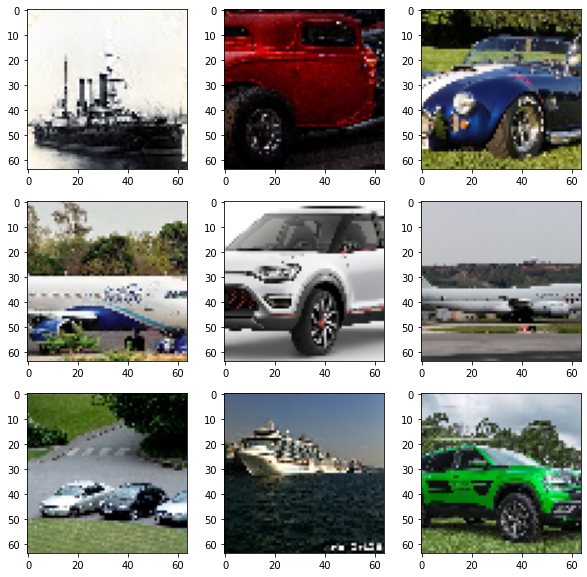

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(X_train[i]/255.0)
# show the figure
plt.show()

# Tratamento dos dados

In [ ]:
# Realizando a normalização das imagens ao dividi-las por 255, além de considerá-las como tipo float a fim de aderir mínimas numerações do array:
# Isso tornará mais fluído o treinamento.

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [ ]:
print(X_train.shape[0], 'Dados - Treino')
print(X_test.shape[0], 'Dados - Teste')

2387 Dados - Treino
597 Dados - Teste


In [ ]:
# Identificando o número de classes

classes = len(Counter(y_test))
classes

3

In [ ]:
# Mudando para to_categorical, para reconhecer os dados:

y_train = to_categorical(y_train, classes)
y_test = to_categorical(y_test, classes)

# K-FOLD

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from collections import Counter

In [ ]:
# Definindo lista para armazenamento das métricas:

accuracy_fold = []
loss_fold = []


In [ ]:
#Definindos os blocos de x e de y
x_block = np.concatenate([X_train, X_test], axis=0)
y_block = np.concatenate([y_train, y_test], axis=0)

#Verificando a compatibilidade de shape dos blocos x e y
print(x_block.shape)
print(y_block.shape)

(2984, 64, 64, 3)
(2984, 3)


In [ ]:
#Definindo o K-fold para validação cruzada

kfold = KFold(n_splits=5,shuffle=True,random_state=False)

# REDE

------------------------------------------------------------------------
Treinando o fold 1 ...
------------------------------------------------------------------------
Epoch 1/15
20/20 [==============================] - 12s 566ms/step - loss: 1.0983 - accuracy: 0.3368 - val_loss: 1.0962 - val_accuracy: 0.3180
Epoch 2/15
20/20 [==============================] - 11s 548ms/step - loss: 1.0760 - accuracy: 0.3897 - val_loss: 1.0290 - val_accuracy: 0.5126
Epoch 3/15
20/20 [==============================] - 11s 544ms/step - loss: 0.9440 - accuracy: 0.5139 - val_loss: 0.8422 - val_accuracy: 0.5816
Epoch 4/15
20/20 [==============================] - 11s 546ms/step - loss: 0.8980 - accuracy: 0.5406 - val_loss: 0.8758 - val_accuracy: 0.5607
Epoch 5/15
20/20 [==============================] - 11s 544ms/step - loss: 0.8324 - accuracy: 0.5825 - val_loss: 0.8078 - val_accuracy: 0.6172
Epoch 6/15
20/20 [==============================] - 11s 546ms/step - loss: 0.8458 - accuracy: 0.5720 - val_loss: 0.8

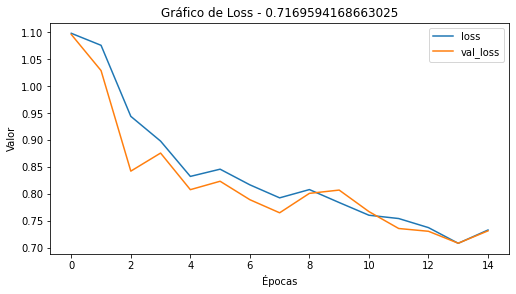

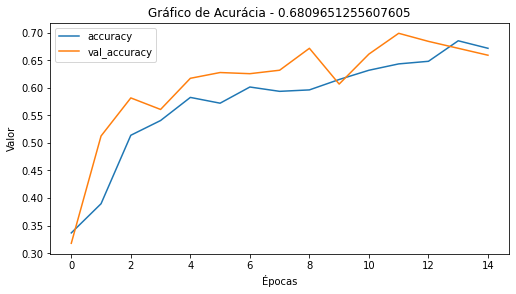

------------------------------------------------------------------------
Treinando o fold 2 ...
------------------------------------------------------------------------
Epoch 1/15
17/20 [========================>.....] - ETA: 1s - loss: 1.0982 - accuracy: 0.3359

KeyboardInterrupt: ignored

In [ ]:

# Implantando o treinamento inicial através dos K-fold
fold_no = 1
classes = 3
for train, test in kfold.split(x_block, y_block):

  # Iniciando o modelo de rede neural CNN
  clear_session()
  model = Sequential()

  model.add(kl.Conv2D(50, (3,3),activation= LeakyReLU(alpha=0.1), padding = 'same'))
  model.add(kl.MaxPooling2D(pool_size=(3, 3)))
  model.add(kl.Dropout(0.2))

  model.add(kl.Conv2D(25, (3,3),activation= LeakyReLU(alpha=0.1), padding = 'same'))
  model.add(kl.MaxPooling2D(pool_size=(3, 3)))
  model.add(kl.Dropout(0.2))

  model.add(kl.Conv2D(25, (2,2),activation= LeakyReLU(alpha=0.1), padding = 'same'))
  model.add(kl.MaxPooling2D(pool_size=(2, 2)))
  model.add(kl.Dropout(0.2))

  model.add(kl.Conv2D(15, (2,2),activation= LeakyReLU(alpha=0.1), padding = 'same'))
  model.add(kl.MaxPooling2D(pool_size=(2, 2)))
  model.add(kl.Dropout(0.2))

  model.add(kl.Flatten())
  model.add(kl.Dense(100, activation= LeakyReLU(alpha=0.1)))
  model.add(kl.Dense(75, activation= LeakyReLU(alpha=0.1)))
  model.add(kl.Dense(50, activation= LeakyReLU(alpha=0.1)))
  model.add(kl.Dense(25, activation= LeakyReLU(alpha=0.1)))
  model.add(kl.Dropout(0.3))
  model.add(kl.Dense(classes, activation='softmax'))

  # Apresentando a estrutura do modelo
  #model.summary()

  # Compilando o modelo
  model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])

  # Exibindo o treinamento do fold
  print('------------------------------------------------------------------------')
  print(f'Treinando o fold {fold_no} ...')
  print('------------------------------------------------------------------------')

  # Armazenando o tempo de execução:
  start = timeit.default_timer()

  # Treinando o modelo
  history = model.fit(X_train, y_train,epochs=15,batch_size =100,validation_split=0.2,verbose=1)

  # Computando o tempo para treinar (fim)
  stop = timeit.default_timer()

  # Apresentando o tempo de treinamento
  print('Tempo: ', stop - start)

  # Gerando a generalização das métricas do modelo
  scores = model.evaluate(x_block, y_block,verbose=0)
  print(f'Resultado por fold {fold_no}: {model.metrics_names[0]} de {scores[0]}; {model.metrics_names[1]} de {scores[1]}')

  accuracy_fold.append(scores[1])
  loss_fold.append(scores[0])

  # Gráfico de loss

  plt.figure(figsize=(15,5))
  plt.subplot(1, 2, 1)
  plt.title(f"Gráfico de Loss - {scores[0]}")
  plt.xlabel("Épocas")
  plt.ylabel("Valor")
  plt.plot(history.history['loss'], label="loss")
  plt.plot(history.history['val_loss'], label="val_loss")
  plt.legend()
  plt.tight_layout(4)
  plt.show()

  # Gráfico de acurácia

  plt.figure(figsize=(15,5))
  plt.subplot(1, 2, 2)
  plt.title(f"Gráfico de Acurácia - {scores[1]}")
  plt.xlabel("Épocas")
  plt.ylabel("Valor")
  plt.plot(history.history['accuracy'], label="accuracy")
  plt.plot(history.history['val_accuracy'], label="val_accuracy")
  plt.legend()
  plt.tight_layout(4)
  plt.show()

  # Incrementando números ao contador de fold
  fold_no = fold_no + 1


In [ ]:
# Visão geral do k-fold inicial


# == Exibindo valores dos K-folds iniciais ==

print('------------------------------------------------------------------------')
print('Resultado por fold')
for i in range(0, len(accuracy_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_fold[i]} - Accuracy: {accuracy_fold[i]}')
print('------------------------------------------------------------------------')


print('Pontuações médias para todos os k-folds:')
print(f'> Accuracy: {np.mean(accuracy_fold)}')
print(f'> Loss: {np.mean(loss_fold)}')
print('------------------------------------------------------------------------')

In [ ]:
# Exibindo estruturalmente a rede empregada:

plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True)

In [ ]:
# Salvando o modelo

model.save('modelo')

# Predição

In [ ]:
print("Tamanho x:",len(X_test))
print("Tamanho y:",len(y_test))

In [ ]:
# Armazenando o resultado do treino junntamente com o predict, para realizar a predição

pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

#_test = np.argmax(y_test, axis = 1)
# Printando a matriz de confusão

print(classification_report(y_test, pred, target_names = ['airplanes',
'cars','ship']))

#Referencias:

https://acervolima.com/coloque-os-graficos-lado-a-lado-no-matplotlib/

https://insightlab.ufc.br/aprenda-a-criar-e-treinar-uma-rede-neural-convolucional-cnn/#:~:text=Ao%20longo%20dos%20anos%2C%20o,automatizada%20de%20ponta%20a%20ponta.

https://www.alura.com.br/conteudo/cnn-redes-neurais-convolucionais-deep-learning-pytorch

https://keras.io/api/layers/convolution_layers/